# Lab 5

## Multiple Linear Regression Model for a Bike Sharing Dataset

This dataset has bike rentals in 2011 and 2012 from Capital bikeshare. The dataset is described here:
http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset	

and is available (day.csv) for download from:
http://archive.ics.uci.edu/ml/machine-learning-databases/00275/




In [1]:
# set up the pyspark environment
import pyspark
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext

# Stop Spark context started by default and start another Spark context
# Allows code to reexecute without error
# sc.stop()
sc = SparkContext("local", "test")

spark = SparkSession(sc)

import pyspark.sql
from pyspark.sql.functions import col, avg

# pandas
import pandas as pd


## Exploratory Data Analysis

### Profile data

Read the bike share dataset into a Pyspark data frame.

In [2]:
path = "/Users/reiven/Documents/Python/CSCI4710/Lab5/Bike-Sharing-Dataset/"
file = "day.csv"
df = spark.read.csv(''.join([path, file]), header=True, inferSchema=True)

# Cache the dataset in memory the first time it is used
# Reread the dataset from memory instead of rereading from disk
df.cache()
# df.printSchema()

DataFrame[instant: int, dteday: timestamp, season: int, yr: int, mnth: int, holiday: int, weekday: int, workingday: int, weathersit: int, temp: double, atemp: double, hum: double, windspeed: double, casual: int, registered: int, cnt: int]

In [14]:
# print ("Dataset has %d rows." % df.count())

Dataset has 731 rows.


In [3]:
df_var = df.select('workingday','casual','windspeed','hum','temp')
# df_var.describe(['casual','windspeed','hum','temp']).show()

In [4]:
# Exploratory Analytics with pandas
# use pandas instead of spark df.
df_pandas = df.toPandas()

print("data types of each column")
df_pandas.dtypes

data types of each column


instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [5]:
# show rows and dim
print("Dataset has %d rows." % len(df_pandas))
print("Dimension of data set:", df_pandas.shape)


Dataset has 731 rows.
Dimension of data set: (731, 16)


In [7]:
# drop dteday, atemp and show first few observation
df_pandas = df_pandas.drop(["dteday","atemp"], axis=1)
print("first 3 observations")
df_pandas.head(3)

first 3 observations


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,1,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,331,654,985
1,2,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,131,670,801
2,3,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,120,1229,1349


In [6]:
# run after finish drop these columns in df_pandas
df = df.drop("dteday").drop("atemp")
# df.take(3)

In [16]:

df_pandas_weekend_only = df_pandas.loc[(df_pandas['weekday'] == 0) | (df_pandas['weekday'] == 6), :]
print("Amount of weekend observation:",df_pandas_weekend_only.shape)
print("Summary statistics for each column")
print(df_pandas_weekend_only.describe([]))  # put [] to omit percentile(25%, 75%)


Amount of weekend observation: (210, 16)
Summary statistics for each column
          instant      season          yr        mnth  holiday     weekday  \
count  210.000000  210.000000  210.000000  210.000000    210.0  210.000000   
mean   365.500000    2.480952    0.500000    6.514286      0.0    3.000000   
std    212.674162    1.120543    0.501195    3.482325      0.0    3.007168   
min      1.000000    1.000000    0.000000    1.000000      0.0    0.000000   
50%    365.500000    2.000000    0.500000    7.000000      0.0    3.000000   
max    730.000000    4.000000    1.000000   12.000000      0.0    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count       210.0  210.000000  210.000000  210.000000  210.000000  210.000000   
mean          0.0    1.352381    0.482833    0.463680    0.623610    0.192559   
std           0.0    0.526448    0.186160    0.166634    0.147952    0.078239   
min           0.0    1.000000    0.059130    0.079070

Scatterplot of 'cnt', 'mnth', 'windspeed','hum','temp', and'weathersit' variables


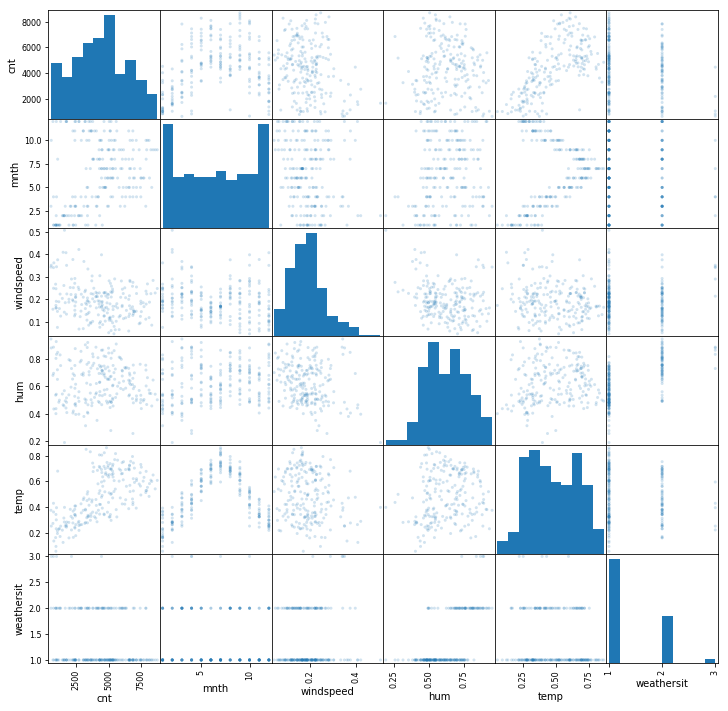

In [17]:
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

print("Scatterplot of 'cnt', 'mnth', 'windspeed','hum','temp', and'weathersit' variables")
scatter_matrix(df_pandas_weekend_only.loc[:, ['cnt', 'mnth', 'windspeed', 'hum', 'temp', 'weathersit']], alpha=0.2,
               figsize=(12, 12))
plt.show()

#### Short interpritation from exploratory analysis

- There is only 731 data, it's not so big to use distributed calculation.
- It mightbe better to normalize value. Most of the value are decimal, but some column seem quite larger compared to that
- About pattern
	- there might seem weak non-linear pattern between mnth and cnt
	- there might seem linear relationship between temp and cnt
	- there might seem non-linear pattern between mnth and temp, but it might cause multicollinearity between cnt, temp, mnth.

#### Split weekend obsevation sets

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_pandas_weekend_only, test_size=0.3, random_state=1)

print("Split data set (train: %d, test:%d)"% (train.shape[0], test.shape[0]))


Split data set (train: 147, test:63)


## Multiple Linear Regression Model

Use sklearn.linear_model.LinearRegression  
LinearRegression requires Pandas data frame for X and Pandas series for the response value. 

No regularization is done for ordinary least squares 
Using Stochastic Gradient Descent 
No scaling done

References:
https://spark.apache.org/docs/latest/mllib-linear-methods.html
http://www.techpoweredmath.com/spark-dataframes-mllib-tutorial/

In [36]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
plt.style.use("ggplot")

In [37]:
train_x = train.loc[:,('windspeed','hum','temp')]
train_y = train.loc[:,('casual')]
test_x = test.loc[:,('windspeed','hum','temp')]
test_y = test.loc[:,('casual')]


lm = linear_model.LinearRegression()
lm.fit(train_x, train_y)
# TODO: next time from here
print('Coefficients: \n', lm.coef_)
print("\nMean squared error: %.2f"
      % np.mean((lm.predict(train_x) - train_y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(train_x, train_y))


pred_train = lm.predict(train_x)
pred_test = lm.predict(test_x)

Coefficients: 
 [-1729.64342494 -1316.46571531  3541.05931714]

Mean squared error: 352095.35
Variance score: 0.57


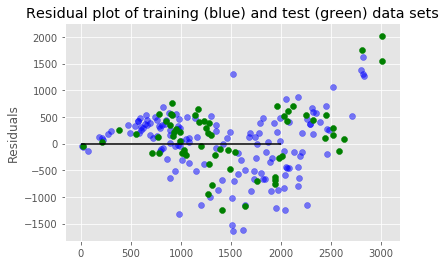

In [38]:
plt.scatter(lm.predict(train_x), lm.predict(train_x) - train_y, c = 'b', alpha=0.5)
plt.scatter(lm.predict(test_x), lm.predict(test_x) - test_y, c = 'g')
plt.hlines(y = 0, xmin = 0, xmax = 2000)
plt.title("Residual plot of training (blue) and test (green) data sets")
plt.ylabel("Residuals")
plt.show()

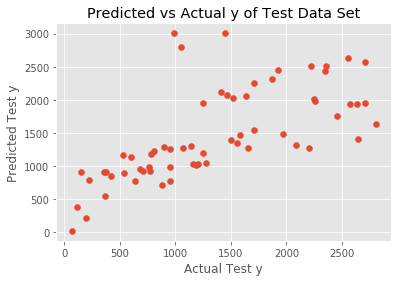

In [39]:
plt.scatter(test_y, pred_test)
plt.title("Predicted vs Actual y of Test Data Set")
plt.ylabel("Predicted Test y")
plt.xlabel("Actual Test y")
plt.show()

#### Short interpritation from exploratory analysis

- The graph "Residual plot of training (blue) and test (green) data sets" shows quite large residuals in middle range(1000\~2000)
- The graph "Predicted vs Actual y of Test Data Set" might show this model describes a weak relationship because it could assume line like $y = x$

### Gradient Boosting regression

In [40]:
# Gradient Boosting regression
# original code is from sklearn tutorial
# (edited)
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# BEGIN: fit regressor
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split':2 
          , 'learning_rate': 0.01, 'loss': 'ls'}

clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(train_x, train_y)
# END: fit regressor

# BEGIN: basic stats(Output)
mse = mean_squared_error(test_y, clf.predict(test_x ))
print("MSE: %.4f" % mse)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % clf.score(train_x, train_y))
# END: basic stats(Output)


MSE: 259854.2772
Variance score: 0.95


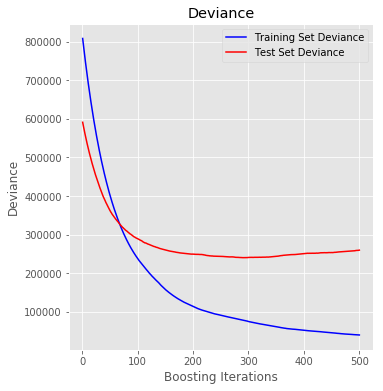

In [41]:
# BEGIN: Plot training deviance
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(test_x )):
    test_score[i] = clf.loss_(test_y, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()


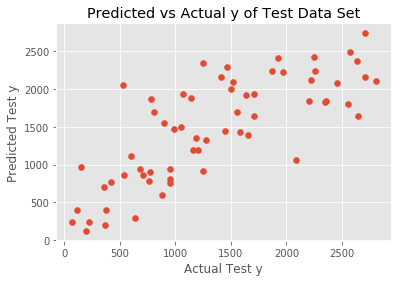

In [42]:

pred_test = clf.predict(test_x)
plt.scatter(test_y, pred_test)
plt.title("Predicted vs Actual y of Test Data Set")
plt.ylabel("Predicted Test y")
plt.xlabel("Actual Test y")
plt.show()


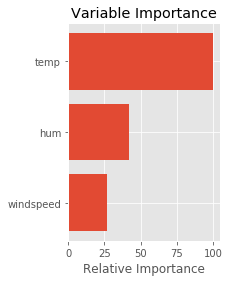

In [43]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_x.columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Short interpritation from exploratory analysis

- As I mentioned in exploratory analysis, the graph "Varianble Importance" show relationship between temp and cnt.
- The graph "Predicted vs Actual y of Test Data Set" shows the prediction improved because of much complex model compared to linear regression

### Logistic regression

In [47]:
# Logistic regression
# original code is from sklearn tutorial
# (edited)
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# use all observation, not weekend observation
train, test = train_test_split(df_pandas, test_size=0.3, random_state=1)
train_x = train.loc[:,("cnt", "holiday")]
train_y = train.loc[:, ("workingday")]
test_x = test.loc[:,("cnt", "holiday")]
test_y = test.loc[:,("workingday")]

# BEGIN: fit regressor
params = {}

clf = LogisticRegression(**params)
clf.fit(train_x, train_y)
test_prediction = clf.predict(test_x)
confusion_matrix_result = confusion_matrix(test_y, test_prediction)
print("confusion matrix result:\n",confusion_matrix_result)

print("precision score:", precision_score(test_y, test_prediction))
print("recall score:", recall_score(test_y, test_prediction))
print("f1 score:", f1_score(test_y, test_prediction))

confusion matrix result:
 [[  0  67]
 [  0 153]]
precision score: 0.695454545455
recall score: 1.0
f1 score: 0.820375335121


#### Short interpritation from exploratory analysis

- The confusion matrix shows that nothing classified as holiday. It is because deviation of the data. Few holiday data and lots of weekday data cause this.

### PySpark Linear Regression

<class 'pyspark.sql.dataframe.DataFrame'>


Coefficients: [108.434932003,-2453.89062764,-2998.16500558,6956.08785566,150.890188099]
Intercept: 2361.814154064905
RMSE: 1352.380068
r2: 0.503459
['__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__metaclass__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_call_java', '_clear', '_copyValues', '_copy_params', '_create_from_java_class', '_defaultParamMap', '_dummy', '_empty_java_param_map', '_from_java', '_java_obj', '_make_java_param_pair', '_new_java_array', '_new_java_obj', '_paramMap', '_params', '_randomUID', '_resetUid', '_resolveParam', '_set', '_setDefault', '_shouldOwn', '_to_java', '_transfer_param_map_from_java', '_transfer_param_map_to_java', '_transfer_params_from_java', '_transfer_params_to_java', '_transform', '


(30, 1)


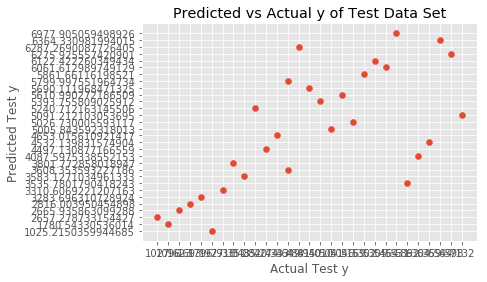

In [106]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import Row

wkend_df = df[df['weekday'] == 0]
# select columns of interest for this model
wkend_df = wkend_df.select('cnt','mnth','windspeed','hum','temp', 'weathersit')
# Cache the dataset in memory the first time it is used
# Reread the dataset from memory instead of rereading from disk
wkend_df.cache()
# wkend_df.printSchema()
# Construct the features vector
assembler = VectorAssembler(
    inputCols=["mnth", "windspeed", "hum", "temp", "weathersit"],
    outputCol="features")

train, test = wkend_df.randomSplit([0.7, 0.3])

feat_df = assembler.transform(train)
test_feat_df = assembler.transform(test)
lr_df = feat_df.drop('mnth','Windspeed','hum','temp','weathersit')
lr_df = feat_df.select('cnt','features').toDF('label', 'features')
lr_test_df = test_feat_df.drop('mnth','Windspeed','hum','temp','weathersit')
lr_test_df = test_feat_df.select('cnt','features').toDF('label','features')
print(type(lr_df))
lr_df.take(5)

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(lr_df)

print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
# Root Mean squared error (RMSE)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
# R squared,...
print("r2: %f" % trainingSummary.r2)

print(dir(lrModel))
predict_y = lrModel.evaluate(lr_test_df).predictions.select("prediction").toPandas()
test_y = test.select("cnt").toPandas()

# Plot Predicted y vs Actual y of Test Data Set
plt.scatter(test_y, predict_y)
plt.title("Predicted vs Actual y of Test Data Set")
plt.ylabel("Predicted Test y")
plt.xlabel("Actual Test y")
plt.show()